In [57]:
# Learning
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

# Preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import analyzer
from tokenizer import create_bag_of_words
from coherence import calculate_uci_coherence, calculate_uci_npmi_coherence, calculate_uci_npmi_coherence_all_docs

#DB
import psycopg2

# Helpers
import numpy as np
import pandas as pd
import pickle
import base64
from collections import defaultdict
import copy

### Get data and connect to DB

In [2]:
## Cleaning database
last_id = 132
# problems = Problem.objects.filter(id__gt=last_id)
# # solutions_obj = Solution.objects.filter(problem__in=problems).update(ignore=True)
# print("Problems to be ignored: %d" % problems.count())

problems = Problem.objects.filter(id__lte=last_id)
# problems = Problem.objects.all()
print("Problems to be used: %d" % problems.count())

solutions_obj = Solution.objects.filter(problem__in=problems, ignore=False).order_by('id')
# solutions_obj = Solution.objects.all().order_by('id')
print("Solutions to be used: %d" % solutions_obj.count())

docs_id = []
questions = []
solutions = []

# Fill separated structures
for sol in solutions_obj:
    docs_id.append(sol.id)
    questions.append(sol.problem.content)
    solutions.append(sol.content)

print("Got %d documents" %(solutions_obj.count()))

Problems to be used: 132
Solutions to be used: 54
Got 54 documents


In [3]:
%%time 
# Insert to DB
connection = psycopg2.connect(user = settings.DATABASES["default"]["USER"],
                          password = settings.DATABASES["default"]["PASSWORD"],
                          host = settings.DATABASES["default"]["HOST"],
                          port = settings.DATABASES["default"]["PORT"],
                          database = settings.DATABASES["default"]["NAME"])
connection.autocommit=True
cursor = connection.cursor()

CPU times: user 0 ns, sys: 3.31 ms, total: 3.31 ms
Wall time: 98.6 ms


In [4]:
def get_where_items(exp_id, cols, table):
    query = "SELECT %s from %s where experiment_id = %s" % (", ".join(cols), table, exp_id) 
    cursor.execute(query)
    where_items = cursor.fetchall()
    return where_items

def get_model_properties(model_pickle, data_features):
    model_db = pickle.loads(base64.b64decode(model_pickle))
    document_topic = model_db.transform(data_features)
    document_clusters = document_topic.argmax(axis=1)
    return document_clusters, model_db.components_.T

In [13]:
exp_id = 26
cols = ["vectorizer", "min_df", "is_binary", "method", "k"]
table = "experiments_solution"
where_items = get_where_items(exp_id, cols, table)[0]
v = eval(where_items[0])
m = where_items[1]
b = where_items[2]
vectorizer_params={'ngram_range': (1,3)}
train_data_features, vectorizer, _ = create_bag_of_words(solutions, v, binary=b, min_df=m, vectorizer_params=vectorizer_params)

# Get new solutions
problems = Problem.objects.exclude(chapter=None)
new_solutions = list(Solution.objects.filter(problem__in=problems, ignore=False
                                            ).order_by('id').values_list('content', flat=True))

test_data_features = vectorizer.transform(new_solutions).toarray()
test_data_features.shape

(65, 236)

In [70]:
select_query = "select model, " + ", ".join(cols) + """ coherence_med5, coherence_med10, coherence_med15 
FROM EXPERIMENTS_2020_02_12 where vectorizer = %s  and min_df = '%s' and is_binary = %s and
method = %s and k = %s and ngrams[1] = 1 and ngrams[2] = 3"""
query = cursor.mogrify(select_query, where_items)
query

b"select model, vectorizer, min_df, is_binary, method, k coherence_med5, coherence_med10, coherence_med15 \nFROM EXPERIMENTS_2020_02_12 where vectorizer = 'CountVectorizer'  and min_df = '0.05' and is_binary = true and\nmethod = 'lda' and k = 12 and ngrams[1] = 1 and ngrams[2] = 3"

In [72]:
cursor.execute(query)
response = cursor.fetchall()

methods = {"lda": defaultdict(list), "kmeans": defaultdict(list)}
metrics = {
    "pmi": copy.deepcopy(methods),
    "npmi": copy.deepcopy(methods),
    "npmi_all": copy.deepcopy(methods)
}

for n in [5,10,15]:
    for idx, row in enumerate(response):
        document_clusters, word_topic = get_model_properties(row[0], test_data_features)
        try:
            metrics["pmi"]["lda"][n].append(calculate_uci_coherence(test_data_features, word_topic, 
                                                      document_clusters, 12, n)[1])
        except RuntimeError:
            print("Cannot calculate UCI Coherence Top-%d for row %d" % (n, idx))
            
print()
for n in [5,10,15]:
    for idx, row in enumerate(response):
        document_clusters, word_topic = get_model_properties(row[0], test_data_features)
        try:
            metrics["npmi"]["lda"][n].append(calculate_uci_npmi_coherence(test_data_features, word_topic, 
                                                            document_clusters, 12, n)[1])
        except RuntimeError:
            print("Cannot calculate NPMI UCI Coherence Top-%d for row %d" % (n, idx))
            
print()
for n in [5,10,15]:
    for idx, row in enumerate(response):
        document_clusters, word_topic = get_model_properties(row[0], test_data_features)
        try:
            metrics["npmi_all"]["lda"][n].append(calculate_uci_npmi_coherence_all_docs(test_data_features, word_topic, 
                                                                         document_clusters, 12, n)[1])
        except RuntimeError:
            print("Cannot calculate NPMI ALL UCI Coherence Top-%d for row %d" % (n, idx))

Cannot calculate UCI Coherence Top-5 for row 1
Cannot calculate UCI Coherence Top-5 for row 3
Cannot calculate UCI Coherence Top-5 for row 4
Cannot calculate UCI Coherence Top-5 for row 5
Cannot calculate UCI Coherence Top-5 for row 7
Cannot calculate UCI Coherence Top-5 for row 8
Cannot calculate UCI Coherence Top-5 for row 11
Cannot calculate UCI Coherence Top-5 for row 13
Cannot calculate UCI Coherence Top-5 for row 15
Cannot calculate UCI Coherence Top-5 for row 16
Cannot calculate UCI Coherence Top-5 for row 17
Cannot calculate UCI Coherence Top-5 for row 19
Cannot calculate UCI Coherence Top-5 for row 20
Cannot calculate UCI Coherence Top-5 for row 21
Cannot calculate UCI Coherence Top-5 for row 27
Cannot calculate UCI Coherence Top-5 for row 28
Cannot calculate UCI Coherence Top-5 for row 29
Cannot calculate UCI Coherence Top-5 for row 33
Cannot calculate UCI Coherence Top-5 for row 34
Cannot calculate UCI Coherence Top-5 for row 37
Cannot calculate UCI Coherence Top-5 for row 3

Cannot calculate UCI Coherence Top-15 for row 68
Cannot calculate UCI Coherence Top-15 for row 69
Cannot calculate UCI Coherence Top-15 for row 70
Cannot calculate UCI Coherence Top-15 for row 71
Cannot calculate UCI Coherence Top-15 for row 72
Cannot calculate UCI Coherence Top-15 for row 73
Cannot calculate UCI Coherence Top-15 for row 74
Cannot calculate UCI Coherence Top-15 for row 75
Cannot calculate UCI Coherence Top-15 for row 76
Cannot calculate UCI Coherence Top-15 for row 77
Cannot calculate UCI Coherence Top-15 for row 78
Cannot calculate UCI Coherence Top-15 for row 80
Cannot calculate UCI Coherence Top-15 for row 81
Cannot calculate UCI Coherence Top-15 for row 82
Cannot calculate UCI Coherence Top-15 for row 83
Cannot calculate UCI Coherence Top-15 for row 84
Cannot calculate UCI Coherence Top-15 for row 85
Cannot calculate UCI Coherence Top-15 for row 86
Cannot calculate UCI Coherence Top-15 for row 87
Cannot calculate UCI Coherence Top-15 for row 88
Cannot calculate UCI

Cannot calculate NPMI UCI Coherence Top-15 for row 18
Cannot calculate NPMI UCI Coherence Top-15 for row 19
Cannot calculate NPMI UCI Coherence Top-15 for row 20
Cannot calculate NPMI UCI Coherence Top-15 for row 21
Cannot calculate NPMI UCI Coherence Top-15 for row 23
Cannot calculate NPMI UCI Coherence Top-15 for row 24
Cannot calculate NPMI UCI Coherence Top-15 for row 25
Cannot calculate NPMI UCI Coherence Top-15 for row 26
Cannot calculate NPMI UCI Coherence Top-15 for row 27
Cannot calculate NPMI UCI Coherence Top-15 for row 28
Cannot calculate NPMI UCI Coherence Top-15 for row 29
Cannot calculate NPMI UCI Coherence Top-15 for row 30
Cannot calculate NPMI UCI Coherence Top-15 for row 33
Cannot calculate NPMI UCI Coherence Top-15 for row 34
Cannot calculate NPMI UCI Coherence Top-15 for row 37
Cannot calculate NPMI UCI Coherence Top-15 for row 38
Cannot calculate NPMI UCI Coherence Top-15 for row 39
Cannot calculate NPMI UCI Coherence Top-15 for row 40
Cannot calculate NPMI UCI Co

Cannot calculate NPMI ALL UCI Coherence Top-15 for row 61
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 62
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 64
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 66
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 68
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 69
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 70
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 71
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 73
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 75
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 77
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 78
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 81
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 82
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 85
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 87
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 89
Cannot calcula

In [75]:
kmeans_pmi = defaultdict(list)
kmeans_npmi = defaultdict(list)
kmeans_npmi_all = defaultdict(list)

for idx in range(100):
    model = KMeans(n_clusters=5)
    clusters_train = model.fit_predict(train_data_features)
    clf = LogisticRegression(multi_class='ovr').fit(train_data_features, clusters_train)
    word_topic = clf.coef_.T

    # Get test solutions clusters
    document_clusters = model.predict(test_data_features)

    for n in [5,10,15]:
        try:
            metrics["pmi"]["kmeans"][n].append(calculate_uci_coherence(test_data_features, word_topic, 
                                                      document_clusters, 5, n)[1])
        except RuntimeError:
            print("Cannot calculate UCI Coherence Top-%d for row %d" % (n, idx))

    print()
    for n in [5,10,15]:
        try:
            metrics["npmi"]["kmeans"][n].append(calculate_uci_npmi_coherence(test_data_features, word_topic, 
                                                            document_clusters, 5, n)[1])
        except RuntimeError:
            print("Cannot calculate NPMI UCI Coherence Top-%d for row %d" % (n, idx))
            
    print()
    for n in [5,10,15]:
        try:
            metrics["npmi_all"]["kmeans"][n].append(calculate_uci_npmi_coherence_all_docs(test_data_features, word_topic, 
                                                                         document_clusters, 5, n)[1])
        except RuntimeError:
            print("Cannot calculate NPMI ALL UCI Coherence Top-%d for row %d" % (n, idx))

Cannot calculate UCI Coherence Top-5 for row 0
Cannot calculate UCI Coherence Top-10 for row 0
Cannot calculate UCI Coherence Top-15 for row 0

Cannot calculate NPMI UCI Coherence Top-5 for row 0
Cannot calculate NPMI UCI Coherence Top-10 for row 0
Cannot calculate NPMI UCI Coherence Top-15 for row 0

Cannot calculate NPMI ALL UCI Coherence Top-5 for row 0
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 0
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 0
Cannot calculate UCI Coherence Top-5 for row 1
Cannot calculate UCI Coherence Top-10 for row 1
Cannot calculate UCI Coherence Top-15 for row 1

Cannot calculate NPMI UCI Coherence Top-5 for row 1
Cannot calculate NPMI UCI Coherence Top-10 for row 1
Cannot calculate NPMI UCI Coherence Top-15 for row 1

Cannot calculate NPMI ALL UCI Coherence Top-5 for row 1
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 1
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 1
Cannot calculate UCI Coherence Top-5 for row 2
Cannot 

Cannot calculate NPMI ALL UCI Coherence Top-15 for row 20
Cannot calculate UCI Coherence Top-5 for row 21
Cannot calculate UCI Coherence Top-10 for row 21
Cannot calculate UCI Coherence Top-15 for row 21

Cannot calculate NPMI UCI Coherence Top-5 for row 21
Cannot calculate NPMI UCI Coherence Top-10 for row 21
Cannot calculate NPMI UCI Coherence Top-15 for row 21

Cannot calculate NPMI ALL UCI Coherence Top-5 for row 21
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 21
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 21
Cannot calculate UCI Coherence Top-5 for row 22
Cannot calculate UCI Coherence Top-10 for row 22
Cannot calculate UCI Coherence Top-15 for row 22

Cannot calculate NPMI UCI Coherence Top-5 for row 22
Cannot calculate NPMI UCI Coherence Top-10 for row 22
Cannot calculate NPMI UCI Coherence Top-15 for row 22

Cannot calculate NPMI ALL UCI Coherence Top-10 for row 22
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 22
Cannot calculate UCI Coherence Top-

Cannot calculate UCI Coherence Top-5 for row 43
Cannot calculate UCI Coherence Top-10 for row 43
Cannot calculate UCI Coherence Top-15 for row 43

Cannot calculate NPMI UCI Coherence Top-5 for row 43
Cannot calculate NPMI UCI Coherence Top-10 for row 43
Cannot calculate NPMI UCI Coherence Top-15 for row 43

Cannot calculate NPMI ALL UCI Coherence Top-5 for row 43
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 43
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 43


Cannot calculate UCI Coherence Top-5 for row 45
Cannot calculate UCI Coherence Top-10 for row 45
Cannot calculate UCI Coherence Top-15 for row 45

Cannot calculate NPMI UCI Coherence Top-5 for row 45
Cannot calculate NPMI UCI Coherence Top-10 for row 45
Cannot calculate NPMI UCI Coherence Top-15 for row 45

Cannot calculate NPMI ALL UCI Coherence Top-5 for row 45
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 45
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 45
Cannot calculate UCI Coherence Top

Cannot calculate NPMI ALL UCI Coherence Top-10 for row 63
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 63
Cannot calculate UCI Coherence Top-5 for row 64
Cannot calculate UCI Coherence Top-10 for row 64
Cannot calculate UCI Coherence Top-15 for row 64

Cannot calculate NPMI UCI Coherence Top-5 for row 64
Cannot calculate NPMI UCI Coherence Top-10 for row 64
Cannot calculate NPMI UCI Coherence Top-15 for row 64

Cannot calculate NPMI ALL UCI Coherence Top-5 for row 64
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 64
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 64
Cannot calculate UCI Coherence Top-10 for row 65
Cannot calculate UCI Coherence Top-15 for row 65

Cannot calculate NPMI UCI Coherence Top-10 for row 65
Cannot calculate NPMI UCI Coherence Top-15 for row 65

Cannot calculate NPMI ALL UCI Coherence Top-10 for row 65
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 65
Cannot calculate UCI Coherence Top-10 for row 66
Cannot calculate UCI Coherenc

Cannot calculate NPMI ALL UCI Coherence Top-10 for row 83
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 83
Cannot calculate UCI Coherence Top-5 for row 84
Cannot calculate UCI Coherence Top-10 for row 84
Cannot calculate UCI Coherence Top-15 for row 84

Cannot calculate NPMI UCI Coherence Top-5 for row 84
Cannot calculate NPMI UCI Coherence Top-10 for row 84
Cannot calculate NPMI UCI Coherence Top-15 for row 84

Cannot calculate NPMI ALL UCI Coherence Top-15 for row 84
Cannot calculate UCI Coherence Top-5 for row 85
Cannot calculate UCI Coherence Top-10 for row 85
Cannot calculate UCI Coherence Top-15 for row 85

Cannot calculate NPMI UCI Coherence Top-5 for row 85
Cannot calculate NPMI UCI Coherence Top-10 for row 85
Cannot calculate NPMI UCI Coherence Top-15 for row 85

Cannot calculate NPMI ALL UCI Coherence Top-5 for row 85
Cannot calculate NPMI ALL UCI Coherence Top-10 for row 85
Cannot calculate NPMI ALL UCI Coherence Top-15 for row 85
Cannot calculate UCI Coherence Top-

### Getting average

In [76]:
for metric, metric_value in metrics.items():
    print(metric)
    for method, method_value in metric_value.items():
        print("\t%s" % method)
        for n, n_value in method_value.items():
            print("\t\t%d" % n)
            value = np.asarray(n_value)
            print("\t\t\tSize: %d Mean: %.2f, Std: %.2f, Median: %.2f" % (value.shape[0], np.mean(value), np.std(value), np.median(value)))
    print()

pmi
	lda
		5
			Size: 54 Mean: -2.04, Std: 0.24, Median: -2.03
		10
			Size: 35 Mean: -2.09, Std: 0.23, Median: -2.07
		15
			Size: 12 Mean: -2.28, Std: 0.18, Median: -2.32
	kmeans
		5
			Size: 25 Mean: -2.55, Std: 0.36, Median: -2.42
		10
			Size: 5 Mean: -2.86, Std: 0.24, Median: -2.74
		15
			Size: 1 Mean: -3.10, Std: 0.00, Median: -3.10

npmi
	lda
		5
			Size: 54 Mean: 0.91, Std: 0.04, Median: 0.91
		10
			Size: 35 Mean: 0.91, Std: 0.03, Median: 0.91
		15
			Size: 12 Mean: 0.88, Std: 0.02, Median: 0.88
	kmeans
		5
			Size: 25 Mean: 0.71, Std: 0.10, Median: 0.74
		10
			Size: 5 Mean: 0.66, Std: 0.06, Median: 0.66
		15
			Size: 1 Mean: 0.63, Std: 0.00, Median: 0.63

npmi_all
	lda
		5
			Size: 86 Mean: 0.75, Std: 0.06, Median: 0.75
		10
			Size: 68 Mean: 0.76, Std: 0.04, Median: 0.76
		15
			Size: 43 Mean: 0.74, Std: 0.02, Median: 0.75
	kmeans
		5
			Size: 46 Mean: 0.55, Std: 0.09, Median: 0.54
		10
			Size: 18 Mean: 0.53, Std: 0.03, Median: 0.53
		15
			Size: 5 Mean: 0.54, Std: 0.03,

In [92]:
from scipy import stats
result = stats.mannwhitneyu(metrics["npmi_all"]["lda"][5], metrics["npmi_all"]["kmeans"][5])
result

MannwhitneyuResult(statistic=156.0, pvalue=1.6748053962000338e-18)

In [94]:
from scipy import stats
result = stats.mannwhitneyu(metrics["npmi_all"]["lda"][5], metrics["npmi_all"]["lda"][10])
result

MannwhitneyuResult(statistic=2462.0, pvalue=0.046560162524456127)

http://www.statskingdom.com/170median_mann_whitney.html

In [101]:
" ".join(["%.6f" % i for i in metrics["npmi_all"]["lda"][5]])

'0.708486 0.638799 0.707900 0.691894 0.729069 0.744210 0.646342 0.759334 0.750542 0.751502 0.717779 0.820067 0.808915 0.806585 0.760576 0.793043 0.687680 0.799570 0.760842 0.757478 0.749076 0.782105 0.729968 0.808301 0.746332 0.796230 0.654011 0.718003 0.819033 0.818372 0.705888 0.640984 0.786371 0.609709 0.850716 0.702273 0.818238 0.845808 0.837489 0.723778 0.837054 0.675261 0.890437 0.741249 0.736368 0.771550 0.630345 0.798898 0.678325 0.733333 0.696077 0.795616 0.710480 0.755257 0.749107 0.715946 0.732866 0.780440 0.727670 0.790013 0.728420 0.742784 0.662050 0.753837 0.778683 0.727398 0.846533 0.807959 0.873439 0.635772 0.738908 0.656733 0.644668 0.770700 0.742904 0.729429 0.761686 0.751220 0.785111 0.699243 0.758405 0.772559 0.765975 0.641684 0.766242 0.761421'

In [103]:
" ".join(["%.6f" % i for i in metrics["npmi_all"]["lda"][10]])

'0.714852 0.729900 0.794723 0.765524 0.703146 0.781720 0.760004 0.788722 0.715753 0.741195 0.744985 0.787239 0.758210 0.758491 0.731673 0.819167 0.804877 0.832514 0.806213 0.739954 0.732365 0.773146 0.803288 0.777436 0.749073 0.748873 0.749070 0.692106 0.804861 0.704642 0.839370 0.859633 0.762687 0.778608 0.695797 0.808275 0.790718 0.737346 0.806686 0.751426 0.711167 0.729765 0.722204 0.764212 0.716226 0.785674 0.774278 0.750505 0.756768 0.744073 0.819454 0.767765 0.784956 0.810844 0.779662 0.764563 0.756038 0.757476 0.708975 0.745930 0.721882 0.773416 0.749741 0.751538 0.797477 0.770130 0.812549 0.707217'

In [102]:
" ".join(["%.6f" % i for i in metrics["npmi_all"]["kmeans"][5]])

'0.474060 0.560124 0.717868 0.530787 0.504001 0.560609 0.662348 0.530889 0.469173 0.642734 0.666661 0.454207 0.702675 0.478509 0.540791 0.654190 0.504001 0.499544 0.487533 0.543475 0.523251 0.667394 0.538967 0.347242 0.439928 0.705755 0.532075 0.701632 0.440787 0.514337 0.618546 0.581340 0.585668 0.631968 0.516259 0.644709 0.493888 0.436386 0.501526 0.585668 0.536569 0.528684 0.559375 0.597340 0.708956 0.333458'

In [79]:
import matplotlib.pyplot as plt

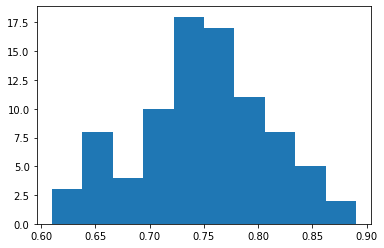

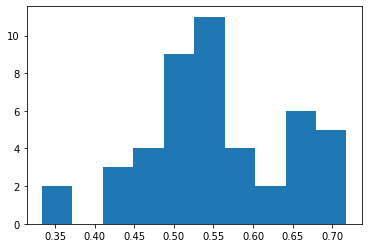

In [80]:
plt.hist(metrics["npmi_all"]["lda"][5])
plt.show()

plt.hist(metrics["npmi_all"]["kmeans"][5])
plt.show()